In [16]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from collections import Counter

In [17]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [2]:
nS, nA = 750, 25
gamma = 0.99
tol = 1e-10

In [3]:
# mask out actions that clinicians never taken
Q_mask = np.load('action_mask.npy')

In [4]:
traj_te = pickle.load(open('trajDr_te.pkl', 'rb'))
# traj_te += pickle.load(open('trajD_va.pkl', 'rb'))
# traj_te = pickle.load(open('trajD_tr.pkl', 'rb'))

trajectories = traj_te

In [5]:
states_te = []
for traj in trajectories:
    for transition in traj:
        states_te.append(transition['s'])

In [6]:
len(states_te)

55315

## set-valued policy

In [7]:
Q_star = np.load('qlearn_Q.npy')
V_star = np.nanmax(Q_star, axis=1)
π_star = np.nanargmax(Q_star, axis=1)

In [8]:
def construct_SVP(Q_pi, Q_star, zeta):
    # Construct the SVP
    # Dictionary of {s: [a1, a2, ...]}
    pi_svp = {}
    for s in range(nS):
        Q_cutoff = min(V_star[s], (1-zeta) * V_star[s]) # lower bound for future return
        Pi_s = np.argwhere(
            np.where(Q_mask[s], Q_pi[s], -np.inf) > Q_cutoff
        )
        if len(Pi_s) > 0:
            assert not np.isnan(Q_pi[s][Pi_s]).all()
            pi_svp[s] = list(Pi_s.flatten())
        else:
            pi_svp[s] = [np.nanargmax(Q_pi[s])] # fall back to the greedy action

    # Tabular form, SxA, (s,a)=1 if a is included in π(s)
    PI_svp = np.zeros((nS, nA), dtype=int)
    for s, pi_s in pi_svp.items():
        for a in pi_s:
            PI_svp[s,a] = 1
    
    return pi_svp, PI_svp

In [9]:
zeta_range = [0.0,
              0.01, 0.02, 0.03, 0.04, 0.05,
              0.06, 0.07, 0.08, 0.09, 0.10,
             ]

In [10]:
# Near-greedy
πs_dict = {}
πs = {}
Qs = {}
for zeta in zeta_range:
    Q_pi = np.load('output_ql/svp_near-greedy_Q_gamma=0.99_zeta={}.npy'.format(zeta))
    pi_svp, PI_svp = construct_SVP(Q_pi, Q_star, zeta)
    πs_dict[zeta] = pi_svp
    πs[zeta] = PI_svp
    Qs[zeta] = Q_pi

## Qualitative

In [11]:
πs_dict[0.05]

{0: [0, 5, 6, 8, 9],
 1: [0, 13],
 2: [0, 5],
 3: [5],
 4: [20],
 5: [0, 13],
 6: [0],
 7: [10, 15],
 8: [10],
 9: [0, 3],
 10: [0, 5, 10],
 11: [15],
 12: [23],
 13: [0, 5],
 14: [19],
 15: [6, 7],
 16: [7],
 17: [0],
 18: [0],
 19: [18],
 20: [5],
 21: [0],
 22: [10],
 23: [6, 10],
 24: [0, 8, 10, 15],
 25: [7, 8],
 26: [0, 10],
 27: [0],
 28: [15],
 29: [0, 8, 9],
 30: [8],
 31: [0, 6, 10],
 32: [0, 6],
 33: [14],
 34: [0, 5],
 35: [0, 5],
 36: [7],
 37: [0, 5, 10],
 38: [6, 7, 15],
 39: [15],
 40: [0, 9],
 41: [0, 5],
 42: [17],
 43: [0, 5, 10],
 44: [0],
 45: [0],
 46: [0, 10],
 47: [0],
 48: [18],
 49: [0, 7, 19],
 50: [8, 13, 14],
 51: [0, 10],
 52: [6, 10],
 53: [0, 10],
 54: [8],
 55: [0],
 56: [0, 5, 10],
 57: [6],
 58: [0, 10],
 59: [0, 10],
 60: [15],
 61: [9],
 62: [0],
 63: [0, 10],
 64: [10],
 65: [15],
 66: [0, 5],
 67: [0, 15],
 68: [0],
 69: [14],
 70: [10],
 71: [0, 5],
 72: [0, 5],
 73: [15],
 74: [0, 8],
 75: [10],
 76: [0, 5],
 77: [0],
 78: [5, 15],
 79: [0, 5, 1

In [12]:
# average policy size
np.mean([len(acts) for _, acts in πs_dict[0.05].items()])

1.776

In [13]:
# fraction of states with more than one actions
np.mean([len(acts) > 1 for _, acts in πs_dict[0.05].items()])

0.548

In [14]:
for zeta in [
#     0.01,
#     0.02, 0.03, 0.04, 
    0.05,
#     0.06, 0.07, 0.08, 0.09, 
#     0.10,
]:
    print('zeta', zeta)
    π = πs_dict[zeta]
    Q = Qs[zeta]
    π_tmp = np.nanargmax(Q, axis=1)
#     fig, axes = plt.subplots(5,5, figsize=(6,6), sharex=True, sharey=True)
#     for a in range(nA):
    a = 5
    row, col = a // 5, a % 5
    vaso, iv = col, row
#     ax = axes[4-row, col]

    cooccur = np.zeros(nA)
#         num = 0
#         for s, pi_s in π.items(): # consider all states
    for s in states_te: # consider states in the test set
        pi_s = π[s]
        pi_s = sorted(pi_s)
        if a == π_tmp[s]:
#             if a == π_star[s]:
#             if a == np.nanargmax(Q[s]):
#                 num += 1
#             if a in pi_s:
            for i, ai in enumerate(pi_s):
                cooccur[ai] += 1

    # Normalize by the max count
    num = cooccur.astype(int).max()
    cooccur = cooccur / num
    cooccur[np.isnan(cooccur)] = 0
#         if zeta == 0.025 or True:
#         cooccur = cooccur * (cooccur >= 0.6)
        

zeta 0.05


In [15]:
cooccur

array([0.35286072, 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.01572829, 0.        , 0.01048553, 0.        ,
       0.20446775, 0.        , 0.        , 0.        , 0.        ,
       0.16890814, 0.        , 0.        , 0.        , 0.        ,
       0.03282425, 0.        , 0.        , 0.        , 0.        ])

In [14]:
import matplotlib

In [15]:
%config InlineBackend.figure_formats = ['png']

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('jet')
new_cmap = truncate_colormap(cmap, 0.0, 0.925)

zeta 0.05


/data4/tangsp/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


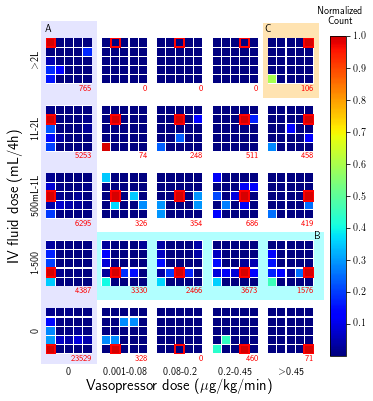

In [21]:
for zeta in [
#     0.01,
#     0.02, 0.03, 0.04, 
    0.05,
#     0.06, 0.07, 0.08, 0.09, 
#     0.10,
]:
    print('zeta', zeta)
    π = πs_dict[zeta]
    Q = Qs[zeta]
    π_tmp = np.nanargmax(Q, axis=1)
    fig, axes = plt.subplots(5,5, figsize=(6,6), sharex=True, sharey=True)
    for a in range(nA):
        row, col = a // 5, a % 5
        vaso, iv = col, row
        ax = axes[4-row, col]

        cooccur = np.zeros(nA)
#         num = 0
#         for s, pi_s in π.items(): # consider all states
        for s in states_te: # consider states in the test set
            pi_s = π[s]
            pi_s = sorted(pi_s)
            if a == π_tmp[s]:
#             if a == π_star[s]:
#             if a == np.nanargmax(Q[s]):
#                 num += 1
#             if a in pi_s:
                for i, ai in enumerate(pi_s):
                    cooccur[ai] += 1
        
        # Normalize by the max count
        num = cooccur.astype(int).max()
        cooccur = cooccur / num
        cooccur[np.isnan(cooccur)] = 0
#         if zeta == 0.025 or True:
#         cooccur = cooccur * (cooccur >= 0.6)
        
        rect = patches.Rectangle((vaso,iv),1,1,linewidth=2,edgecolor='red',facecolor='none')
        ax.add_patch(rect)
        ax.text(5, -0.1, '{}'.format(num), fontsize=8, color='r', ha='right', va='top')
        
        ax = sns.heatmap(cooccur.reshape((5,5)),
                        square=True, 
                        cmap=new_cmap, #YlGnBu
                        linewidths=.1, 
#                         xticklabels=1, yticklabels=1, 
                        xticklabels=0, yticklabels=0, 
                        vmin=0, vmax=1,
                        ax=ax,
                        cbar=False,
                        )
        ax.invert_yaxis()
        ax.set_xlim(0,5)
        ax.set_ylim(0,5)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Vasopressor dose ($\mu$g/kg/min)", fontsize=15)
    plt.ylabel("IV fluid dose (mL/4h)", fontsize=15)
#     plt.title('$\zeta={}$'.format(zeta))
    
    xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '$>$0.45']
    yranges = ['0', '1-500', '500mL-1L', '1L-2L', '$>$2L']
    
    for pos, text in enumerate(xranges):
        plt.text(pos*6/29+2.5/29, -0.04, text, fontsize=10, ha='center', va='center')
    for pos, text in enumerate(yranges):
        plt.text(-0.04, pos*6/29+2.5/29, text, fontsize=10, ha='center', va='center', rotation='vertical')
    
    ########
    ## Marking regions of interest
    ax0 = plt.gca()
    ax0.set_zorder(-100)
    plt.text(0.01, 1.01, 'A', fontsize=10, ha='center', va='center')
    ax0.add_patch(patches.Rectangle((-0.02, -0.015), 0.21, 1.05, facecolor='blue', alpha=0.1, clip_on=False))
    plt.text(1.015, 0.375, 'B', fontsize=10, ha='center', va='center')
    ax0.add_patch(patches.Rectangle((0.19, 0.18), 0.85, 0.21, facecolor='cyan', alpha=0.3, clip_on=False))
    plt.text(0.83, 1.01, 'C', fontsize=10, ha='center', va='center')
    ax0.add_patch(patches.Rectangle((0.81, 0.8), 0.21, 0.23, facecolor='orange', alpha=0.3, clip_on=False))
    plt.xlim(0,1)
    plt.ylim(0,1)
    ########
    
    cbar = fig.colorbar(ax.get_children()[0], ax=fig.get_axes(), shrink=0.98, 
                        ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
#     cbar.ax.set_yticklabels(['0.6', '0.7', '0.8', '0.9', '1'])
#     plt.text(1.2, 0.4, '< 0.6', fontsize=10, ha='center', va='center')
    
    plt.text(1.1, 1.05, 'Normalized\n Count', fontsize=10, ha='center', va='center')
    
#     cbar.ax.yaxis.get_major_ticks()[0].set_visible(False)
#     cbar.ax.yaxis.majorTicks[0].tick1line.set_markersize(0)
#     fig.add_subplot(111, frameon=False)
#     plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     cmap_ = ax.get_children()[0].cmap
#     vmax, vmin = 1, 0.8
#     colors = plt.get_cmap('viridis')(np.linspace(1.-(vmax-vmin)/float(vmax), 1, cmap_.N))
#     color_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_viridis', colors)
#     cax, _  = matplotlib.colorbar.make_axes(plt.gca())
#     norm = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)
#     cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm,)
    
    plt.savefig('fig/mimic-action_zeta={}.pdf'.format(zeta), bbox_inches='tight')
    plt.show()